In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
import math
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    pl.seed_everything(seed)

set_random_seed(42)

device = "gpu" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

hyperparams = {
    "input_size": 6,  
    "hidden_layers": [64, 128, 256, 128, 64, 20], 
    "output_size": 1,  
    "learning_rate": 0.001,  
    "batch_size": 32,  # вроде стандартное значение
    "max_epochs": 50,  # вроде стандартное значение
    "early_stopping_patience": 10,  
    "reduce_lr_patience": 5,  
}

def load_data():
    df = pd.read_csv('/Users/veronika/Downloads/clasdb_pi_0_p.txt', delimiter='\t', header=None)
    df.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'dsigma_dOmega', 'error', 'id']
    df['phi'] = df.phi.apply(lambda x: math.radians(x))
    df['cos_phi'] = df['phi'].apply(lambda x: math.cos(x))
    df['sin_phi'] = df['phi'].apply(lambda x: math.sin(x))
    df['Ebeam'] = df['Ebeam'].round(decimals=2)
    df = df.replace({"Ebeam": {2.45: 2.44, 1.65: 1.64}})
    df = df.drop(df[df['dsigma_dOmega'] == 0].index)
    df = df.drop('id', axis=1)
    df = df.reset_index(drop=True)
    df = df.iloc[df[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']].drop_duplicates().index]
    df = df.reset_index(drop=True)
    return df
    
def plot_angle_distribution(df):
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    sns.violinplot(x=df['dsigma_dOmega'], color='skyblue')
    plt.title(r'Violinplot dsigma_dOmega')
    plt.xlabel(r'dsigma_dOmega')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df['phi'], color='lightgreen')
    plt.title(r'Boxplot dsigma_dOmega')
    plt.xlabel(r'dsigma_dOmega')
    
    plt.tight_layout()
    plt.show()

Seed set to 42


Using cpu device


In [58]:
def print_unique_energies(df):
    unique_energies = df['Ebeam'].round(2).unique()
    
    unique_energies_sorted = sorted(unique_energies)
    print("Значения энергии:")
    for energy in unique_energies_sorted:
        print(f"{energy:.2f} GeV")

Значения энергии:
1.64 GeV
2.04 GeV
2.44 GeV
5.75 GeV


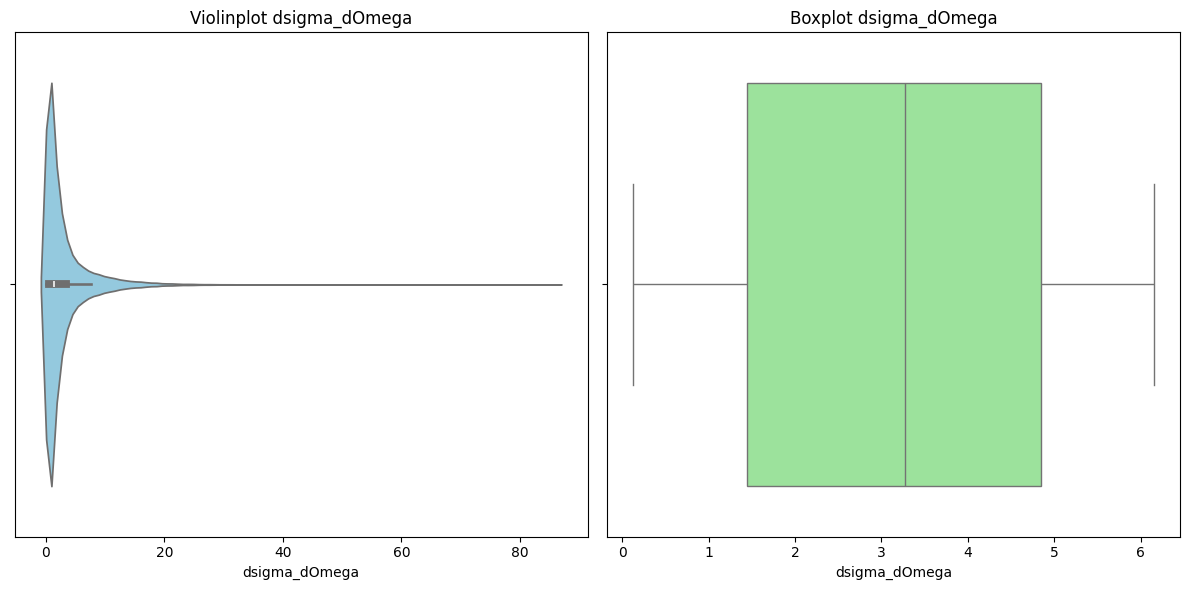

In [59]:
df = load_data()
print_unique_energies(df)
plot_angle_distribution(df)

In [52]:
#Мне показалось, что так как у нас нет точек за пределами "усов" на boxplot, то это говорит о том, что нет выбросов. 
#Если смотреть на violinplot, то можно сказать, распределение имеет
#длинный хвост слева, то есть большинство значений сосредоточено в диапазоне низких значений, а затем резко падает с увеличением значений.
#Такой violinplot говорит о значительных выбросах или аномально высоких значениях.
#В общем, я тут в замешательстве....

In [60]:
class PiZeroDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe
        self.features = dataframe[['Ebeam', 'W', 'Q2', 'cos_theta', 'cos_phi', 'sin_phi']].values
        self.targets = dataframe['dsigma_dOmega'].values
        self.weights = 1 / dataframe['error'].values
        self.scaler = StandardScaler()
        self.features = self.scaler.fit_transform(self.features)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return {
            'features': torch.tensor(self.features[idx], dtype=torch.float32),
            'target': torch.tensor(self.targets[idx], dtype=torch.float32),
            'weights': torch.tensor(self.weights[idx], dtype=torch.float32)
        }

In [61]:
class PiZeroModel(pl.LightningModule):
    def __init__(self, hyperparams):
        super(PiZeroModel, self).__init__()
        self.hyperparams = hyperparams
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(hyperparams["input_size"], hyperparams["hidden_layers"][0]))
        for i in range(1, len(hyperparams["hidden_layers"])):
            self.layers.append(nn.Linear(hyperparams["hidden_layers"][i-1], hyperparams["hidden_layers"][i]))
        self.layers.append(nn.Linear(hyperparams["hidden_layers"][-1], hyperparams["output_size"]))
        self.learning_rate = hyperparams["learning_rate"]
        self.train_losses = [] 
        self.val_losses = []  
        self.epoch_train_loss = [] 
        self.epoch_val_loss = []    

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = torch.relu(layer(x))
        x = self.layers[-1](x)
        return x

    def training_step(self, batch, batch_idx):
        features = batch['features']
        targets = batch['target']
        weights = batch['weights']
        predictions = self(features)
        loss = torch.sqrt(torch.mean(weights * (predictions - targets) ** 2))
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.epoch_train_loss.append(loss.item()) 
        return loss

    def validation_step(self, batch, batch_idx):
        features = batch['features']
        targets = batch['target']
        predictions = self(features)
        loss = torch.sqrt(torch.mean((predictions - targets) ** 2))
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.epoch_val_loss.append(loss.item())  
        return loss

    def on_train_epoch_end(self):
        avg_train_loss = sum(self.epoch_train_loss) / len(self.epoch_train_loss)
        self.train_losses.append(avg_train_loss) 
        self.epoch_train_loss.clear()

    def on_validation_epoch_end(self):
        avg_val_loss = sum(self.epoch_val_loss) / len(self.epoch_val_loss)
        self.val_losses.append(avg_val_loss) 
        self.epoch_val_loss.clear() 

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=self.hyperparams["reduce_lr_patience"], verbose=True
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': scheduler,
            'monitor': 'val_loss'
        }

In [62]:
class PiZeroTrainer:
    def __init__(self, df, hyperparams):
        self.df = df
        self.hyperparams = hyperparams
        self.models = {}
        self.trainers = {}
        self.loss_histories = {}

    def split_data_by_energy(self):
        energy_groups = self.df['Ebeam'].unique()
        datasets = {}
        for energy in energy_groups:
            datasets[energy] = self.df[self.df['Ebeam'] == energy]
        return datasets

    def train_models(self):
        energy_datasets = self.split_data_by_energy()
        for energy, dataset in energy_datasets.items():
            train_df, val_df = train_test_split(dataset, test_size=0.2, random_state=42)
            train_dataset = PiZeroDataset(train_df)
            val_dataset = PiZeroDataset(val_df)
            train_loader = DataLoader(train_dataset, batch_size=self.hyperparams["batch_size"], shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=self.hyperparams["batch_size"], shuffle=False)

            checkpoint_callback = ModelCheckpoint(
                monitor='val_loss',
                dirpath='checkpoints/', 
                filename=f'best-model-{{epoch:02d}}-{{val_loss:.2f}}', 
                save_top_k=1,
                mode='min',
            )
            early_stop_callback = EarlyStopping(
                monitor='val_loss',
                patience=self.hyperparams["early_stopping_patience"],
                verbose=True,
                mode='min'
            )

            trainer = pl.Trainer(
                max_epochs=self.hyperparams["max_epochs"],
                callbacks=[checkpoint_callback, early_stop_callback],
                log_every_n_steps=10
            )

            model = PiZeroModel(self.hyperparams)
            trainer.fit(model, train_loader, val_loader)

            self.models[energy] = model
            self.loss_histories[energy] = {
                'train_losses': model.train_losses,
                'val_losses': model.val_losses
            }
    def plot_training_curves(self):
        for energy, losses in self.loss_histories.items():
            print(f"Model for Ebeam = {energy}")
            
            train_losses = losses['train_losses']
            val_losses = losses['val_losses']
            
            if not train_losses or not val_losses:
                print(f"No training/validation data for Ebeam = {energy}")
                continue
            
            plt.figure(figsize=(10, 5))
            plt.plot(train_losses, label='Train Loss')
            plt.plot(val_losses, label='Validation Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss (RMSE)')
            plt.title(f'Training and Validation Loss for Ebeam = {energy}')
            plt.legend()
            plt.show()

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/veronika/checkpoints exists and is not empty.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name   | Type       | Params | Mode 
----------------------------------------------
0 | layers | ModuleList | 84.3 K | train
----------------------------------------------
84.3 K    Trainable params
0         Non-trainable params
84.3 K    Total params
0.337     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 5.707


Validation: |                                             | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.201 >= min_delta = 0.0. New best score: 5.506


Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 5.466


Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 5.466. Signaling Trainer to stop.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/veronika/checkpoints exists and is not empty.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name   | Type       | Params | Mode 
----------------------------------------------
0 | layers | ModuleList | 84.3 K | train
----------------------------------------------
84.3 K    Trainable params
0         Non-trainable params
84.3 K    Total params
0.337     Total estimated model params size (MB)
8         Modules in train

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 3.173


Validation: |                                             | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.096 >= min_delta = 0.0. New best score: 3.077


Validation: |                                             | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 3.076


Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 3.061


Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 3.049


Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 3.049. Signaling Trainer to stop.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/veronika/checkpoints exists and is not empty.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name   | Type       | Params | Mode 
----------------------------------------------
0 | layers | ModuleList | 84.3 K | train
----------------------------------------------
84.3 K    Trainable params
0         Non-trainable params
84.3 K    Total params
0.337     Total estimated model params size (MB)
8         Modules in train

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.151


Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.151. Signaling Trainer to stop.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/veronika/checkpoints exists and is not empty.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name   | Type       | Params | Mode 
----------------------------------------------
0 | layers | ModuleList | 84.3 K | train
----------------------------------------------
84.3 K    Trainable params
0         Non-trainable params
84.3 K    Total params
0.337     Total estimated model params size (MB)
8         Modules in train

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 3.835


Validation: |                                             | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 3.814


Validation: |                                             | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.089 >= min_delta = 0.0. New best score: 3.725


Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 3.725. Signaling Trainer to stop.


Model for Ebeam = 1.64


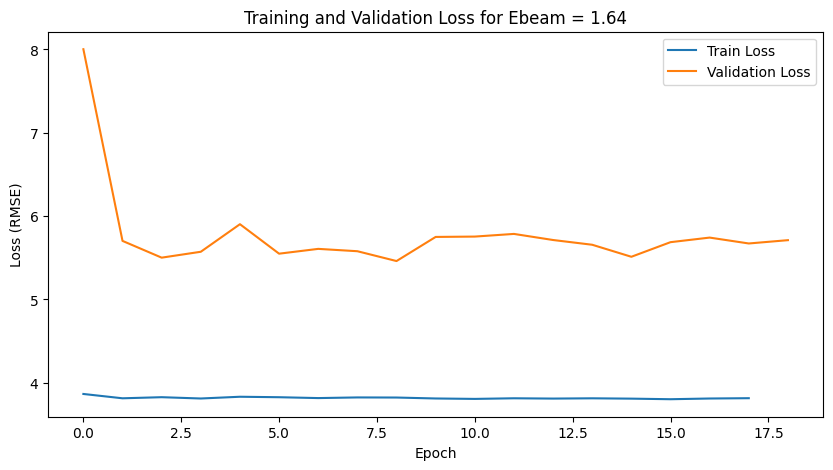

Model for Ebeam = 2.44


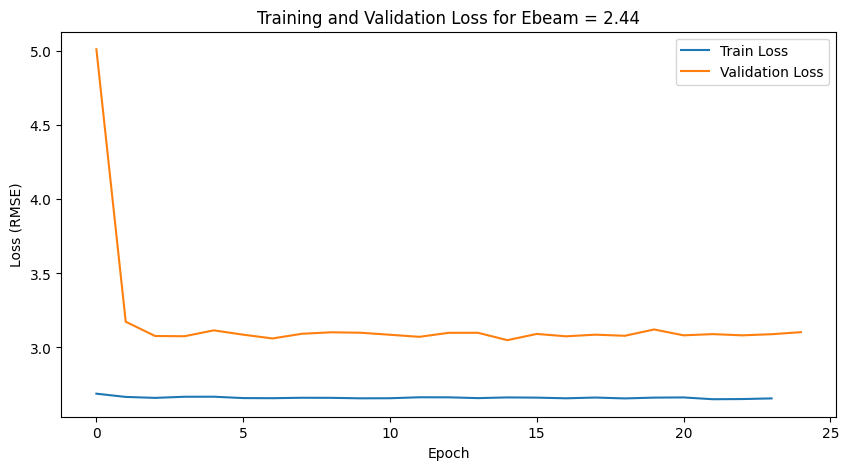

Model for Ebeam = 5.75


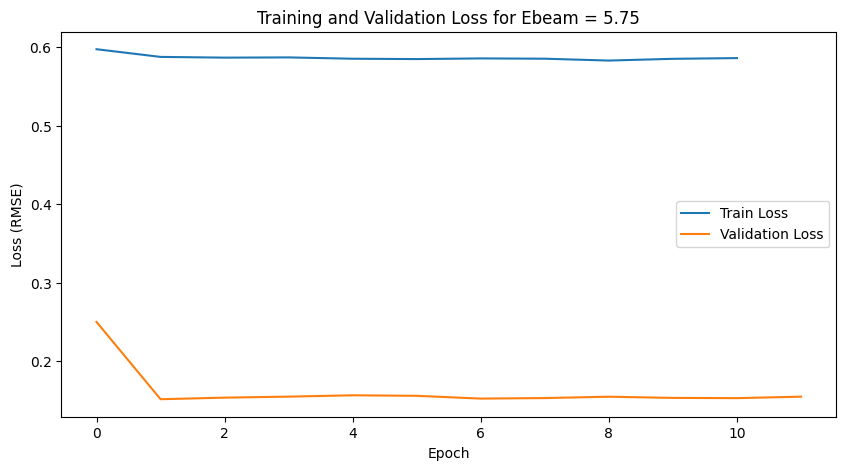

Model for Ebeam = 2.04


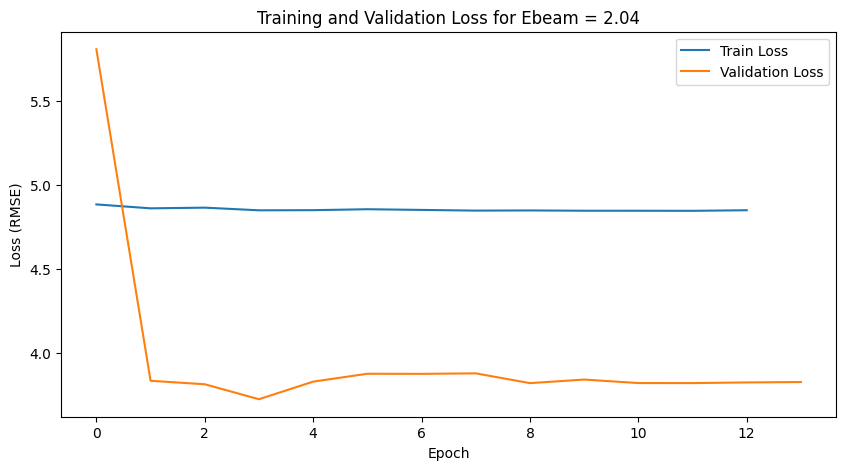

In [63]:
df = load_data()
trainer = PiZeroTrainer(df, hyperparams)
trainer.train_models()
trainer.plot_training_curves()